In [1]:
pip install jupyter_http_over_ws

# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему мы сделали выбор в пользу VGGFace2?**

**ВПИШИТЕ ОТВЕТ ЗДЕСЬ**

**-----**

*Возможный ответ: Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам горазддо полезне и помогут обучить модель лучше и быстрее*

**-----**




А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [2]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to c:\users\1\appdata\local\temp\pip-req-build-k2ys_kem
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8384 sha256=17e3ad7f2241e66b6a309904d9a81f39090669101898455936fcd6be4dbc2fdf
  Stored in directory: C:\Users\1\AppData\Local\Temp\pip-ephem-wheel-cache-3yaltf00\wheels\24\de\3d\9a0fad8c64abbc63b7fb8ddcdf1aa0a4c04a98d7936e989a29
Successfully built keras-vggface



In [3]:
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [4]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально

from keras_vggface.vggface import VGGFace

#vggface = VGGFace(model='resnet50') # or VGGFace() as default

Ошибка появляется потому что, пример из репозитория не использует режим eager_execution, который мы всегда включали в своих примерах для удобства разработки и соответствия новым стандартам tensorflow. 

Но это не проблема. Мы за вас заранее выполнили код выше без eager_execution и сохранили модель с помощью save_model. Она находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:


In [5]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: C:\Users\1\Jupyter\resnet50face.h5
166MB [00:14, 11.6MB/s] 


'resnet50face.h5'

In [6]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [7]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [10]:
!apt-get update
!apt-get install wget

"apt-get" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"apt-get" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [12]:
import wget
picture = wget.filename_from_url('https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg')
#! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

После загрузки запустим полный пример из репозитория:

In [13]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img(picture, target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: '5c4ea940d2b08.jpg'

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [14]:
from pathlib import Path
from collections import Counter

In [19]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = 'C:/Users/1/Jupyter/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: C:\Users\1\Jupyter\UTKFace.tar.gz
107MB [00:09, 11.5MB/s] 
tar: Error opening archive: Failed to open '/tmp/UTKFace.tar.gz'
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: C:\Users\1\Jupyter\train_val_split_utk.csv
100%|█████████████████████████████████████████████████████████████████████████████| 1.08M/1.08M [00:00<00:00, 11.0MB/s]


'train_val_split_utk.csv'

In [21]:
data_folder = Path("C:/Users/1/Jupyter/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


In [22]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,23_1_2_20170116172910708.jpg.chip.jpg,0.198276,2,1
1,28_0_1_20170113150719161.jpg.chip.jpg,0.241379,1,0
2,26_1_0_20170116234741431.jpg.chip.jpg,0.224138,0,1
3,37_0_3_20170119202516470.jpg.chip.jpg,0.318966,3,0
4,60_0_0_20170109013457906.jpg.chip.jpg,0.517241,0,0


In [23]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [24]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

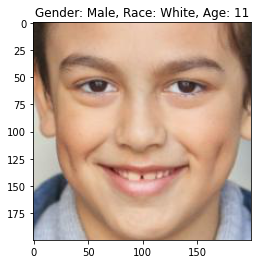

In [25]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


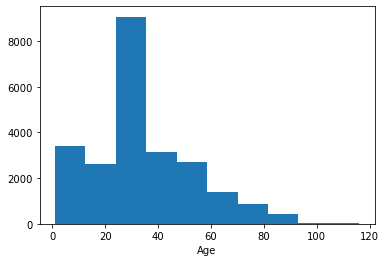

In [26]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Предподготовка закончена. А теперь ваша очередь:) Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы предлагаем вам воспользоваться `tensorflow.keras.preprocessing.image.ImageDataGenerator`

###a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    
    preprocessed = utils.preprocess_input(image_, version=2)
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

###b)

Для генерации картинок раньше мы использовали `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому вы должны воспользоваться более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(df_train,
                                                x_col='img_name',
                                                y_col='gender',
                                                directory=str(data_folder),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='binary')

val_generator = image_gen.flow_from_dataframe(df_val,
                                              x_col='img_name',
                                              y_col='gender',
                                              directory=str(data_folder),
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                              class_mode='binary')





# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [30]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


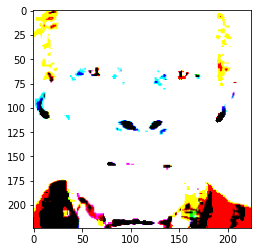

In [31]:
plt.imshow(sample_images[30])
print(gender_mapping[int(sample_labels[30])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [32]:
print(sample_images[30].max(), sample_images[30].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

121.5047 -113.0912


###с)
**Реализуйте функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


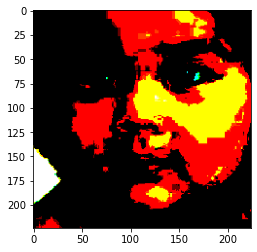

In [33]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >

    image = np.copy(vggface_image)
    image = utils.preprocess_input(image, data_format='channels_last', version=2)


    
    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##Здание 3. Обучение модели предсказания пола

В этом задании вы должны обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"
*   Рекомендуется в model.fit(...) использовать steps_per_epoch=25, для того чтобы проверка на валидации происходила чаще и вы могли более точно отслеживать прогресс. Полная эпоха ~140 итераций.
*   За точность выше 94% -- дополнительные баллы.



In [18]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
path = Path("/content/drive/My Drive/Skillbox/ML средний/hw5/")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "best_checkpoint.hdf5"  
cpt_path = str(path / cpt_filename)

Mounted at /content/drive/


In [19]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [34]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [37]:
# < YOUR CODE STARTS HERE >

In [38]:
# Обучение модели предсказания пола
base_model.trainable = True
len(base_model.layers)

175

In [41]:
fine_tune_at = 170
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 6,145
Non-trainable params: 23,557,056
_________________________________________________________________


In [42]:
EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/30
149/25 [==================================================================================================================================================================================] - 19s 125ms/step - loss: 1.0466 - acc: 0.6333

Epoch 00001: val_acc improved from -inf to 0.63333, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint.hdf5
25/25 [==============================] - 30s 1s/step - loss: 0.9647 - acc: 0.6000 - val_loss: 0.9839 - val_acc: 0.6333
Epoch 2/30
149/25 [==================================================================================================================================================================================] - 18s 123ms/step - loss: 0.9288 - acc: 0.6602

Epoch 00002: val_acc improved from 0.63333 to 0.66022, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint.hdf5
25/25 [==============================] - 31s 1s/step - loss: 0.8632 - acc: 0.6338 - val_loss: 0.8596 - val_acc: 

In [46]:
model_gender = load_model(cpt_path)
loss, acc = model_gender.evaluate_generator(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

Very good! Can you improve accuracy?


In [ ]:
#Недостаточно. Увеличим количество слоев и уменьшим скорость обучения

In [60]:
# < YOUR CODE ENDS HERE >
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00002),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 8,931,329
Non-trainable params: 14,631,872
_________________________________________________________________


In [61]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/20
149/25 [==================================================================================================================================================================================] - 20s 132ms/step - loss: 0.3221 - acc: 0.8563

Epoch 00001: val_acc improved from -inf to 0.85627, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint.hdf5
25/25 [==============================] - 33s 1s/step - loss: 0.3368 - acc: 0.8512 - val_loss: 0.3619 - val_acc: 0.8563
Epoch 2/20
149/25 [==================================================================================================================================================================================] - 20s 132ms/step - loss: 0.2235 - acc: 0.8956

Epoch 00002: val_acc improved from 0.85627 to 0.89557, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint.hdf5
25/25 [==============================] - 34s 1s/step - loss: 0.1794 - acc: 0.9287 - val_loss: 0.2642 - val_acc: 

In [63]:
model_gender = load_model(cpt_path)
loss, acc = model_gender.evaluate_generator(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

Very good! Can you improve accuracy?


In [52]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

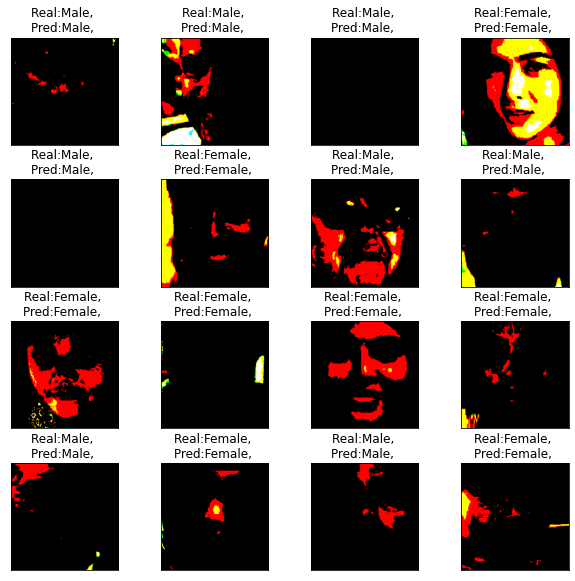

In [89]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Здание 4. Обучение модели предсказания расы

В этом задании вы должны обучить модель предсказания расы с точностью более 80% на валидационном сете. 

*   Используя код аналогичный тому, что выше, реализуйте модель предсказания расы
*   Для начала определите генератор данных
    *  нужно указать class_mode="sparse" и изменить "y_col"
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_race/checkpoint_best.h5"
*   За точность выше 85% -- дополнительные баллы.



In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [90]:
# < YOUR CODE STARTS HERE >

In [91]:
df_train.head()

,img_name,age,race,gender,is_train
1,36_1_1_20170112210525117.jpg.chip.jpg,0.310345,1,1,1
2,4_1_2_20161219205238948.jpg.chip.jpg,0.034483,2,1,1
5,27_0_4_20170103235800445.jpg.chip.jpg,0.232759,4,0,1
6,28_1_3_20170119152713848.jpg.chip.jpg,0.241379,3,1,1
7,68_0_1_20170113152656361.jpg.chip.jpg,0.586207,1,0,1


In [ ]:
train_generator = image_gen.flow_from_dataframe(df_train,
                                                x_col='img_name',
                                                y_col='race',
                                                directory=str(data_folder),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='sparse')

val_generator = image_gen.flow_from_dataframe(df_val,
                                              x_col='img_name',
                                              y_col='race',
                                              directory=str(data_folder),
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                              class_mode='sparse')

drive.mount('/content/drive/', force_remount=True)
path = Path("/content/drive/My Drive/Skillbox/ML средний/hw5/")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename1 = "best_checkpoint_for_task_two.hdf5"  
cpt_path1 = str(path / cpt_filename1)
new_base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
new_base_model.summary()
fine_tune_at = 165
for layer in new_base_model.layers[:fine_tune_at]:
  layer.trainable = False
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model_two = tf.keras.Sequential([new_base_model,
                             tf.keras.layers.Dense(5)])
model_two.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_two.summary()

In [97]:
EPOCHS = 20
history = model_two.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/20
149/25 [==================================================================================================================================================================================] - 20s 135ms/step - loss: 1.6807 - acc: 0.5573

Epoch 00001: val_acc improved from -inf to 0.55726, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint_for_task_two.hdf5
25/25 [==============================] - 34s 1s/step - loss: 1.1857 - acc: 0.6562 - val_loss: 1.5960 - val_acc: 0.5573
Epoch 2/20
149/25 [==================================================================================================================================================================================] - 21s 138ms/step - loss: 1.4733 - acc: 0.6348

Epoch 00002: val_acc improved from 0.55726 to 0.63480, saving model to /content/drive/My Drive/Skillbox/ML средний/hw5/best_checkpoint_for_task_two.hdf5
25/25 [==============================] - 35s 1s/step - loss: 0.7405 - acc: 0.7925 - va

In [ ]:
# < YOUR CODE ENDS HERE >

In [100]:
next_model_race = load_model(cpt_path1)
loss, acc = next_model_race.evaluate_generator(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

Very good! Can you improve accuracy?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

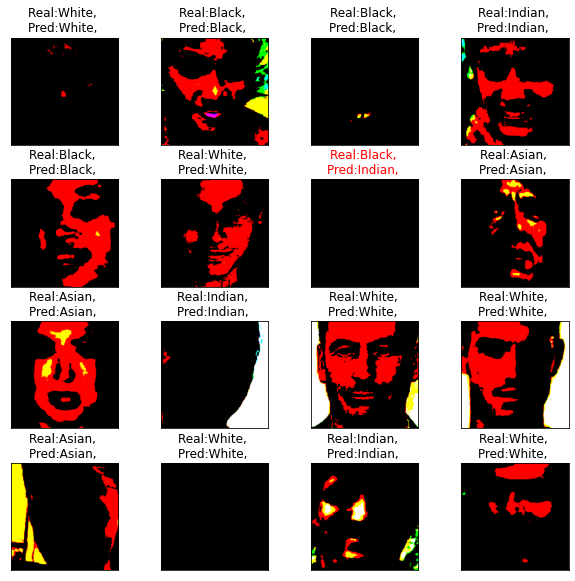

In [101]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = next_model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [35]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [48]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# < YOUR CODE STARTS HERE >
# переменная model должна содержать модель для дальнейшего обучения
l1_output = base_model(input_layer)
l2 = tf.keras.layers.Dense(128, name='Layer2')(l1_output)
l3 = tf.keras.layers.Dense(512, name='Layer3')(l2)
l4 = tf.keras.layers.Dense(1, name='gender', activation='sigmoid')(l3)
l5 = tf.keras.layers.Dense(5, name='race', activation='sigmoid')(l3)
l6 = tf.keras.layers.Dense(1, name='age')(l3)
model = tf.keras.Model(inputs=input_layer, outputs=[l4, l5, l6])

# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         23561152    input_3[0][0]                    
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 128)          262272      model[2][0]                      
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 512)          66048       Layer2[0][0]                     
____________________________________________________________________________________________

In [39]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [40]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype("float32"), 3, axis=1)
        labels = [labels[0].reshape((len(labels[0]),)),
                  labels[1].reshape((len(labels[1]),)),
                  labels[2].reshape((len(labels[2]),)),
                  ]
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


А теперь перейдем к обучению:

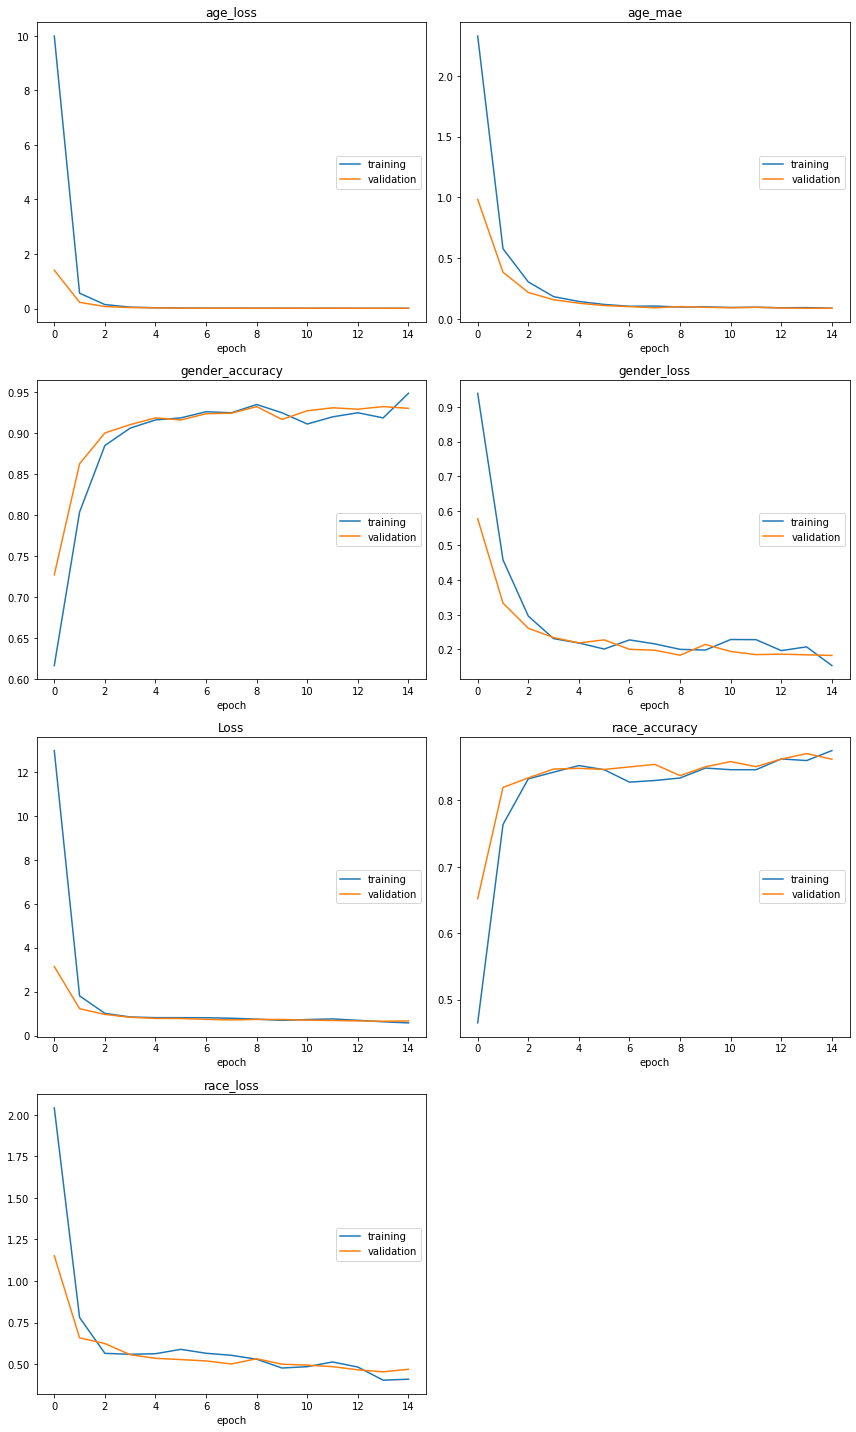

age_loss
	training         	 (min:    0.012, max:    9.990, cur:    0.012)
	validation       	 (min:    0.012, max:    1.409, cur:    0.012)
age_mae
	training         	 (min:    0.088, max:    2.328, cur:    0.088)
	validation       	 (min:    0.087, max:    0.983, cur:    0.087)
gender_accuracy
	training         	 (min:    0.616, max:    0.949, cur:    0.949)
	validation       	 (min:    0.727, max:    0.933, cur:    0.930)
gender_loss
	training         	 (min:    0.153, max:    0.939, cur:    0.153)
	validation       	 (min:    0.183, max:    0.577, cur:    0.183)
Loss
	training         	 (min:    0.575, max:   12.971, cur:    0.575)
	validation       	 (min:    0.650, max:    3.138, cur:    0.663)
race_accuracy
	training         	 (min:    0.465, max:    0.875, cur:    0.875)
	validation       	 (min:    0.652, max:    0.871, cur:    0.862)
race_loss
	training         	 (min:    0.403, max:    2.042, cur:    0.409)
	validation       	 (min:    0.453, max:    1.152, cur:    0.469)

E

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005,) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("C:/Users/1/Jupyter/")
assert path.exists()
cpt_filename3 = "best_checkpoint_for_task_three.hdf5"  
cpt_path3 = str(path / cpt_filename3)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path3, monitor='age_mae', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=25, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [50]:
model_multitask = load_model(cpt_path3)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
148/148 [==============================] - 157s 1s/step - loss: 0.6641 - gender_loss: 0.1834 - race_loss: 0.4688 - age_loss: 0.0118 - gender_accuracy: 0.9293 - race_accuracy: 0.8621 - age_mae: 0.0858
Well done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

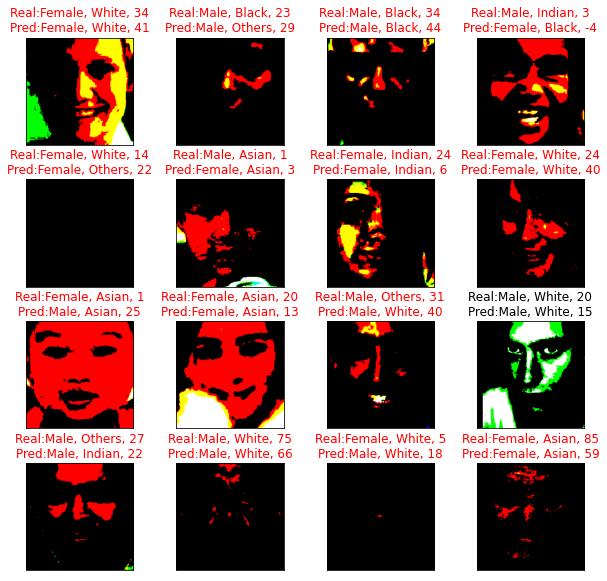

In [53]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: C:\Users\1\Jupyter\me.jpg
2.34MB [00:00, 11.1MB/s]


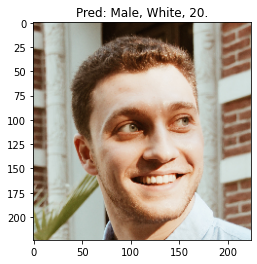

In [54]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# я получился немного моложе :)

#Заключение 

Это было очень сложное и важное домашнее задание. Надеемся, вы с ним справились успешно и готовы к переходу к следующему модулю! Удачи!